### Attenuation in fakequakes

There are two kinds of attenuation in FQ **intrinsic**, which we'll call $Q_i$ and **scattering** attenuation which we'll call $Q_c$. Intrinsic attenuation depends on whatever values for Qs and Qp are defiend in the mod file, **however** there are 4 different ways in which the representative path length is chosen by the code to apply the attenuation. The code will ray trace through the velocity model provided in the .mod file between whatever stationa nd subfault is being worked on. 

The four different methods of selecting the representative ray for the path length are:

* **'no_moho'** : Do not allow moho turning rays to be used when calculating path length. From these non-moho rays keep the fastest (shortest travel time). If only Moho rays are available keep the shallowest turning one.

* **'shallowest'** :  look at the ray turning depths, keep the shallowest turning one.

* **'fastest'** : picks the first arriving ray irrespective of where it turns

* **'direct'** : draws a straight line from source to site, NO RAY TRACING!

Let's make a ray plot to see what these would look like


In [6]:
import numpy as np
from mudpy import hfsims
from obspy.taup import TauPyModel
from pyproj import Geod
from obspy.geodetics import kilometer2degrees
from mudpy.forward import get_mu
from matplotlib import pyplot as plt
%matplotlib notebook


#FQ parameters that will be needed
home='/Users/tnye/FakeQuakes/FQ_status/new_Q_model/new_fault_model/m7.85/'
project_name='standard_parameters'
model_name = 'mentawai_newq.mod'
Qexp=0.4
structure = np.genfromtxt(home+project_name+'/structure/'+model_name)

#freq vector used later for Q(f)
f = np.logspace(-1,2)

Load an already made rupture and let's pick some subfault from it to use as a representative source

In [47]:
#rupture
fault = np.genfromtxt('/Users/tnye/FakeQuakes/FQ_status/new_Q_model/new_fault_model/m7.85/standard_parameters/output/ruptures/mentawai.000000.rupt')
kfault = 2000 # This si the representative source

#depth of source and other properties of medium that I will need later
zs=fault[kfault,3]
mu,alpha,beta=get_mu(structure,zs,return_speeds=True)
rho=mu/beta**2

#load velocity model
velmod = TauPyModel(model=home+project_name+'/structure/'+model_name.split('.')[0])

#Pick a station, whichever one, and get source to station distance and other things used later
sta_lon = 99.5796; sta_lat = 0.7955   #This si AL2H
g=Geod(ellps='WGS84')
lon_source=fault[kfault,1]
lat_source=fault[kfault,2]
azimuth,baz,dist=g.inv(lon_source,lat_source,sta_lon,sta_lat)
dist_in_degs=kilometer2degrees(dist/1000.)

3 arrivals
	S phase arrival at 103.220 seconds
	S phase arrival at 125.308 seconds
	S phase arrival at 125.308 seconds


<IPython.core.display.Javascript object>


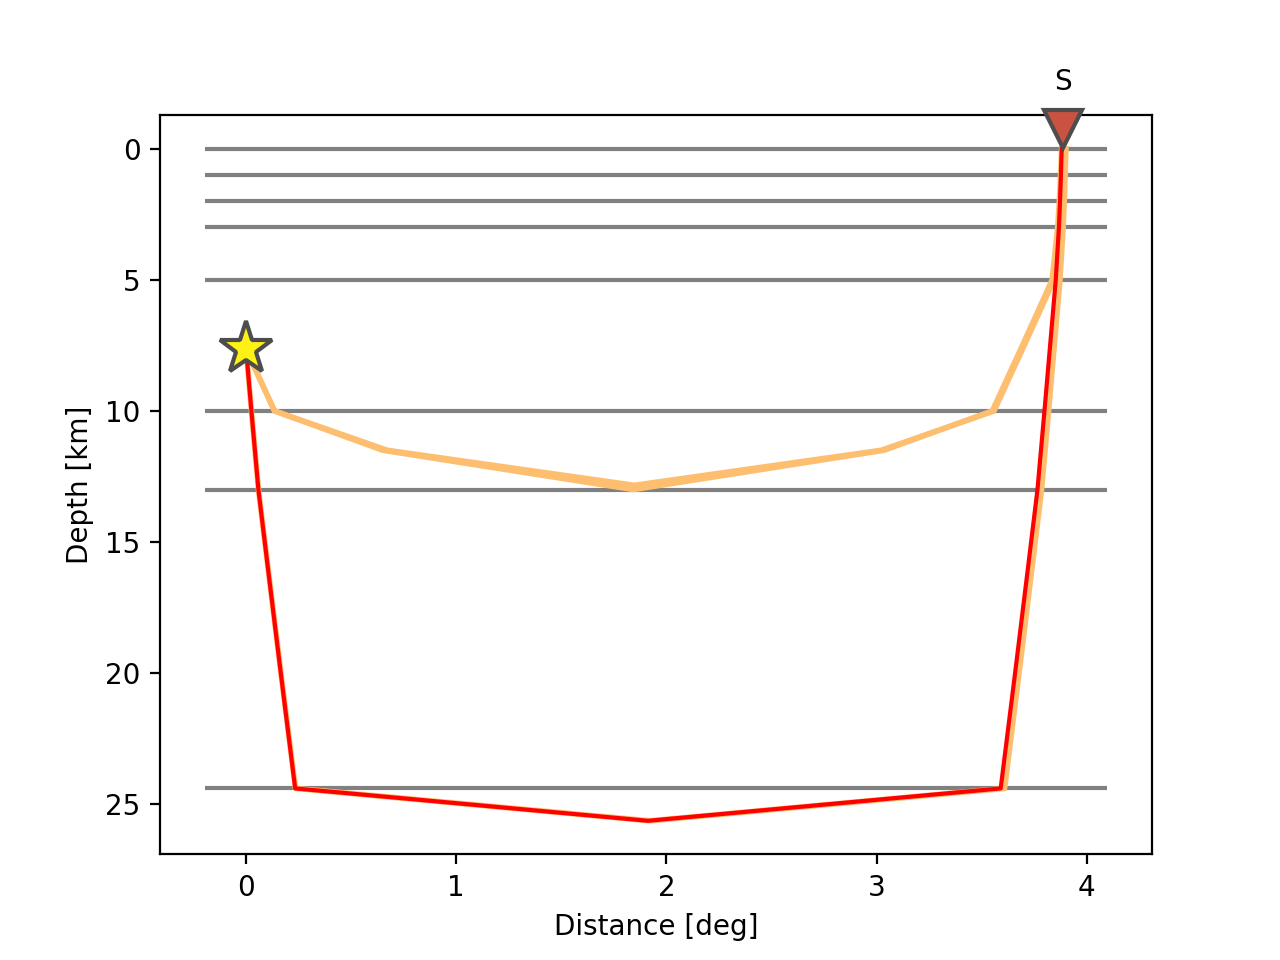

In [48]:
#get S ray paths and make plot
Spaths=velmod.get_ray_paths(zs,dist_in_degs,phase_list=['S','s'])
print(Spaths)  # This shows the ray arrival times

#Make plot fo all rays and highlight first arriving ray
ax = Spaths.plot_rays(plot_type="cartesian",label_arrivals='True')

#Keep first arriving ray, plot it ina  different color
fastestS=Spaths[0]
ax.plot(fastestS.path['dist']*57,fastestS.path['depth'],c='r')


So, the above is a good example of the compelxities invovled. The moho is at ~25km and a ray that turns just below it is being used to calcualte the path length. Deep rays have a longer path length but laos travel through higher quality material and result in less attenuation. Also, we don't actually know amplitude information so whether this is the right path length to pick is not known. And also notice there are so many more paths through the low quality crust.

The solution in FQ is to introduce a tunable parameter, Qmethod, defined above and let the user pick whatever fits a regional GMM best.

Let's explore the frequency domain impact of those choices (if any). We'll pick the differnt rays and calcualte the Q(f) spectra. The code below is exactly what is in hfsims_parallel.run_parallel_hfsims() with some variables renamed for this notebook.

In [49]:
moho_depth  = velmod.model.moho_depth

# Q method = 'no moho'
            
#get turning depths and arrival times of S rays
turning_depths = np.zeros(len(Spaths))
S_ray_times = np.zeros(len(Spaths))

for kray in range(len(Spaths)):
    turning_depths[kray] = Spaths[kray].path['depth'].max()
    S_ray_times[kray] = Spaths[kray].path['time'].max()

#Keep only rays that turn above Moho
i = np.where(turning_depths < moho_depth)[0]

if len(i) == 0: #all rays turn below Moho, keep shallowest turning
    i_min_depth = np.argmin(turning_depths)
    nomohoS = Spaths[i_min_depth]

else:  #Keep fastest arriving ray that turns above Moho
    Spaths = [Spaths[j] for j in i]  #Rays turning above Moho, NOTE: I hate list comprehension
    S_ray_times = S_ray_times[i]
    i_min_time = np.argmin(S_ray_times)
    nomohoS = Spaths[i_min_time]
    

                    
# Qmethod = 'shallowest'
                                
#get turning depths and arrival times of S rays
turning_depths = np.zeros(len(Spaths))
                
for kray in range(len(Spaths)):
    turning_depths[kray] = Spaths[kray].path['depth'].max()

i_min_depth = np.argmin(turning_depths)
shallowestS = Spaths[i_min_depth]
                
            
        
# Qmethod = 'fastest' or 'direct':
directS = Spaths[0]

Now build the Q(f) function for each choice

In [50]:
#####    No moho     #####
Sray = nomohoS

take_off_angle_S = Sray.takeoff_angle

#Get attenuation due to geometrical spreading (from the path length)
path_length_S = hfsims.get_path_length(Sray,zs,dist_in_degs)
path_length_S = path_length_S*100 #to cm

Q_S_nomoho = hfsims.get_attenuation(f,structure,Sray,Qexp,scattering='off',
                               Qc_exp=0,baseline_Qc=150)



#####    Shallowest    #####
Sray = shallowestS

take_off_angle_S = Sray.takeoff_angle

#Get attenuation due to geometrical spreading (from the path length)
path_length_S = hfsims.get_path_length(Sray,zs,dist_in_degs)
path_length_S = path_length_S*100 #to cm



Q_S_shallowest = hfsims.get_attenuation(f,structure,Sray,Qexp,scattering='off',
                               Qc_exp=0,baseline_Qc=150)


#####    Fastest    #####
Sray = directS

take_off_angle_S = Sray.takeoff_angle

#Get attenuation due to geometrical spreading (from the path length)
path_length_S = hfsims.get_path_length(Sray,zs,dist_in_degs)
path_length_S = path_length_S*100 #to cm



Q_S_fastest = hfsims.get_attenuation(f,structure,Sray,Qexp,scattering='off',
                               Qc_exp=0,baseline_Qc=150)


#####    direct (no ray tracing)    #####
Q_S_direct = hfsims.get_attenuation_linear(f,structure,zs,dist,Qexp,Qtype='S')

<IPython.core.display.Javascript object>


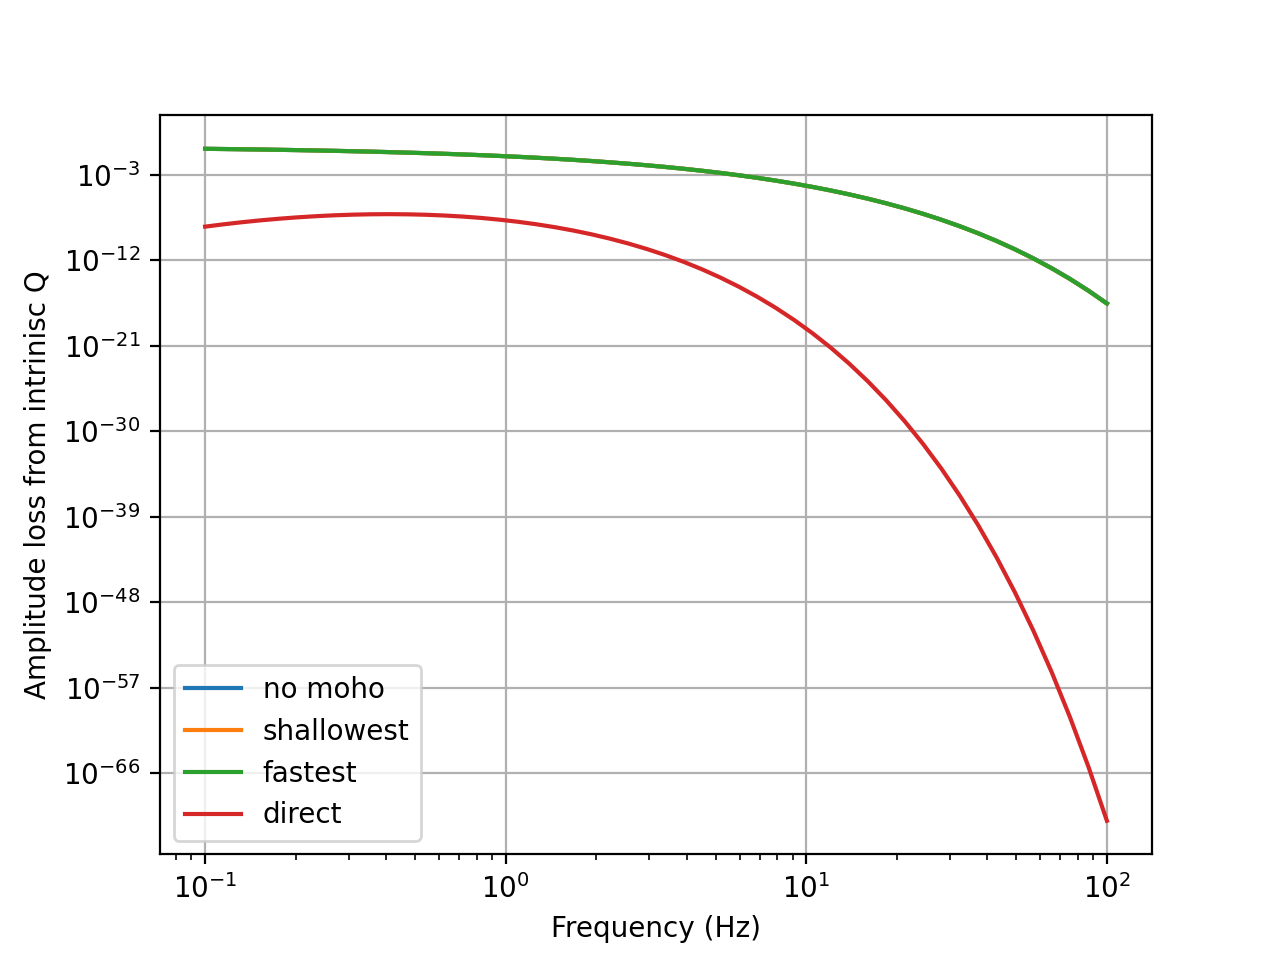

Text(0, 0.5, 'Amplitude loss from intrinisc Q')

In [51]:
plt.figure()
plt.loglog(f,Q_S_nomoho,label='no moho')
plt.loglog(f,Q_S_shallowest,label='shallowest')
plt.loglog(f,Q_S_fastest,label='fastest')
plt.loglog(f,Q_S_direct,label='direct')

plt.grid()
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude loss from intrinisc Q')

So it can have an imapct but remember this is all dependent on source to site distance and depth of the source especially!

### Scattering Q

We use the functional form $Q_c = Q_bf^{k}$ where $Q_b$ is what is called baselineQ in the code and $k$ is Qc_exp. See https://pubs.geoscienceworld.org/ssa/bssa/article/106/5/1939/350869/Coda-Q-in-the-Northern-Cascadia-Subduction.

The code let's you combine scattering and intrinisc attenuation using the following expression
$$
Q_{total} = \frac{1}{(1/Q_c + 1/Q_i)}
$$

Let's comapre the effec tof including scattering Q into the 'shallowest' Qmethod

<IPython.core.display.Javascript object>


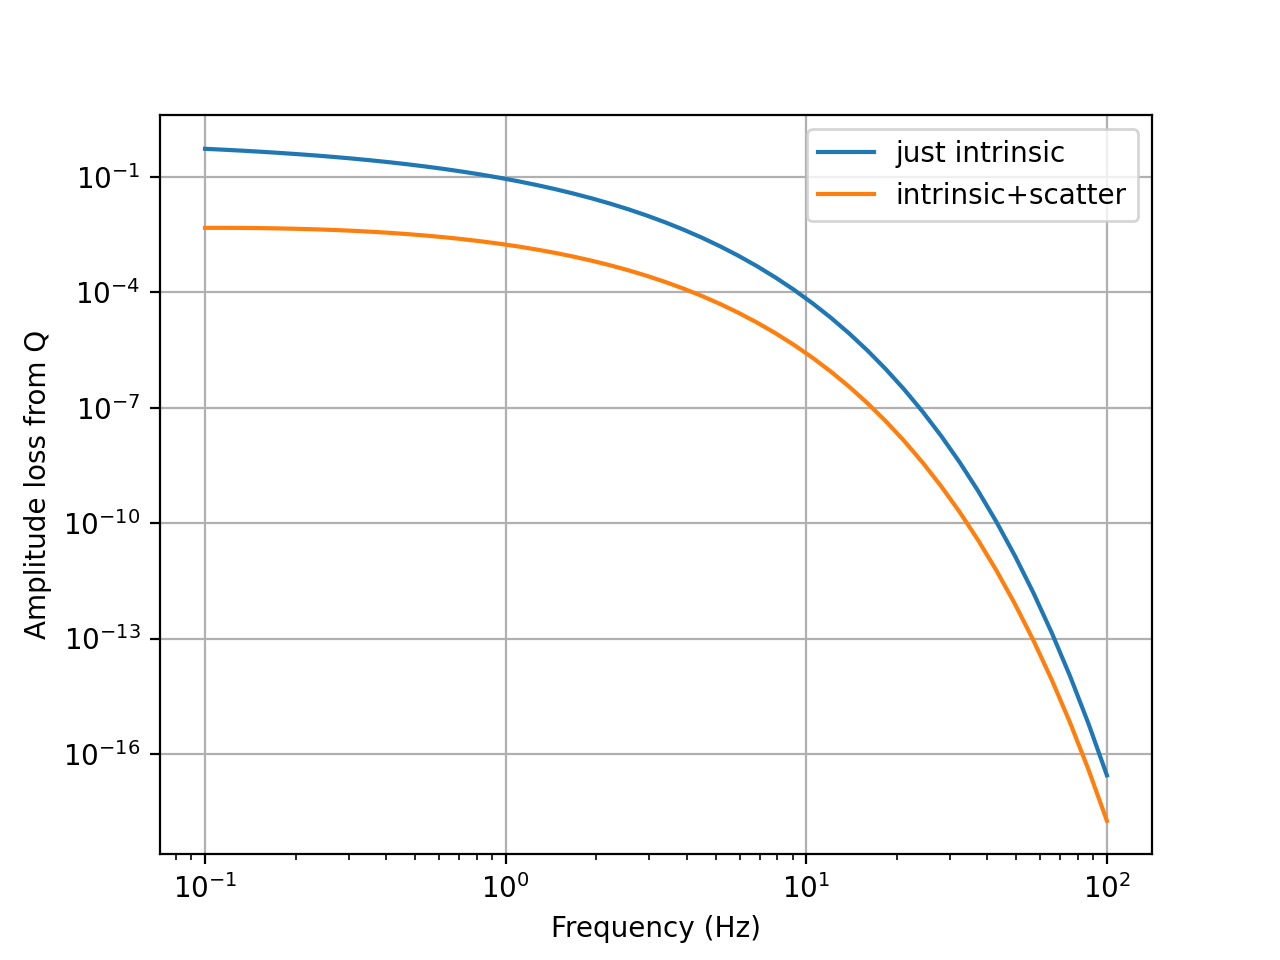

Text(0, 0.5, 'Amplitude loss from Q')

In [53]:
# Add Qc calcualtion
baselineQ = 100
Qc_exp = 0.68
Q_S_shallow_with_scatter = hfsims.get_attenuation(f,structure,Sray,Qexp,scattering='on',
                               Qc_exp=Qc_exp,baseline_Qc=baselineQ)

plt.figure()
plt.loglog(f,Q_S_shallowest,label='just intrinsic')
plt.loglog(f,Q_S_shallow_with_scatter,label='intrinsic+scatter')

plt.grid()
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude loss from Q')

It can have a funky effect! And remember that any increase to attenuation will be msot obvious at longer distances. So Qc_exp can modualte the frequency dependent behavior while baselineQ can modualte the overall